In [12]:
import re
import jieba
import pandas as pd
from gensim import corpora, models, similarities
from sklearn.model_selection import train_test_split
import numpy.linalg
import numpy as np
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
table = pd.read_csv('news.csv')

#在这个文件中，我们会用刚那学过的分类方法简单贝叶斯完成一个新闻文本分类任务。我们针对1万新闻文本进行了设计， 首先我们设计特征。把每个文章类型的关键词通过tf-idf提取， 在同一类文章里加权tifidf值得到top 50作为热词，并通过他们在每一类文章里出现的频率来作为简单贝叶斯的特征。 然后根据每篇文章里热词出现的频率来计算文章属于某一个分类的概率

## Segment the documents with jieba

In [14]:
# jieba custom setting.
jieba.set_dictionary('jieba_dict/dict.txt.big')
# filter stopwords
stopwordset = set()
with open('jieba_dict/stopwords_s.txt','r',encoding='utf-8') as sw:
    for line in sw:
        stopwordset.add(line.strip('\n'))

chinese_pattern = re.compile(r'[\u4e00-\u9fff]+')
        
def segment(document):
    if type(document) is str:
        words = jieba.cut(document, cut_all=False)
        # return space-separated words as a string
        return [word for word in words if (word not in stopwordset) and (chinese_pattern.match(word))]
    else:
        return []

In [33]:
print (chinese_pattern)

re.compile('[\\u4e00-\\u9fff]+')


## gensim TF-IDF 
The IDF should be based on all the documents in the corpus
A quite nice tutorial on how to compute TF-IDF using gensim:
http://tawara.hatenablog.com/entry/2016/11/08/021408
应用语言的第一个
我们这节课上的重要内容是首先学会对文字进行编码，也就是说把文字转化为一个向量。 而这里我们用标准化的工具dictonry进行。  
为了得到每个词语的重要性， 我们引入if-idf工具。tf的意思是说在单个文本中文章出现的概率（次数除以字数）。 idf的意思是说出现该单词的文章在整个文章库里的出现频率的倒数的对数 。这两个数的乘机表明了这个单词所含的信息量，或者说关键词指数。  

In [15]:
# build dictionary and corpus
table['doc_words'] = table.content.apply(segment)
dictionary = corpora.Dictionary(table['doc_words'] )
table['corpus'] = table['doc_words'].apply(dictionary.doc2bow)

# compute IDF of words
# TODO: build this tfidf model with a larger corpus e.g. wikipedia
model = models.TfidfModel(table.corpus)
table['tfidf'] = model[table.corpus]

Building prefix dict from /Users/apple/AiTrain/bayes/jieba_dict/dict.txt.big ...
Loading model from cache /var/folders/8x/0w1hzjy55bjd8jp5xz1qgcfm0000gn/T/jieba.u9348f0f4150045e29d6ddf332f14dfc6.cache
Loading model cost 2.087 seconds.
Prefix dict has been built succesfully.


In [8]:
table.iloc[:3]

,Unnamed: 0,content,id,tags,time,title,doc_words,corpus,tfidf
0,0,牵动人心的雄安新区规划细节内容和出台时间表敲定。日前，北京商报记者从业内获悉，京津冀协同发...,6428905748545732865,"['财经', '白洋淀', '城市规划', '徐匡迪', '太行山']",2017-06-07 22:52:55,雄安新区规划“骨架”敲定，方案有望9月底出炉,"[牵动人心, 雄安, 新区, 规划, 细节, 内容, 出台, 时间表, 敲定, 日前, 北京...","[(0, 6), (1, 1), (2, 1), (3, 3), (4, 2), (5, 2...","[(0, 0.005554342859788116), (1, 0.007470250835..."
1,1,去年以来，多个城市先后发布了多项楼市调控政策。在限购、限贷甚至限售的政策“组合拳”下，房地产...,6428954136200855810,"['财经', '碧桂园', '万科集团', '投资', '广州恒大']",2017-06-08 08:01:13,“红五月”不红 房企资金链压力攀升,"[去年, 以来, 多个, 城市, 先后, 发布, 多项, 楼市, 调控, 政策, 限购, 限...","[(0, 1), (3, 3), (13, 1), (17, 1), (41, 1), (5...","[(0, 0.002081356679198299), (3, 0.012288034179..."
2,2,在今年中国国际自行车展上，上海凤凰自行车总裁王朝阳表示，共享单车的到来把我们打懵了，影响更是...,6420576443738784002,"['财经', '自行车', '凤凰', '王朝阳', '汽车展览']",2017-05-16 12:03:00,凤凰自行车总裁：共享单车把我们打懵了,"[今年, 中国, 国际, 自行车, 展上, 上海, 凤凰, 自行车, 总裁, 王, 朝阳, ...","[(15, 1), (53, 1), (167, 1), (262, 1), (396, 1...","[(15, 0.057457146244872616), (53, 0.0543395377..."


# tf_idf 是提取词语重要性的重要的方法，假设一个词语在某文章中经常出现，而在整个文档里不经常出现， 则它可能是和这个文档高度相关的信息。比如上面文字中的今日， 中国这种词， 就是冗余信息。 而财经，凤凰一旦出现往往tf-idf的值很高

In [16]:
corpus_tfidf = model[table.corpus]
#corpus

In [17]:
index = similarities.MatrixSimilarity(corpus_tfidf)

/Volumes/My_Mac/program/anaconda/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [18]:
sims = index[corpus_tfidf]

**TODO**: visualize artciles

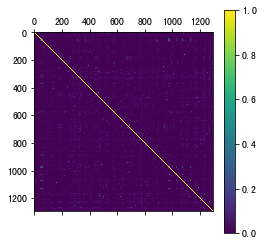

In [19]:
plt.matshow(sims)
plt.colorbar()

In [41]:
# ortho diagonalization
w, v = numpy.linalg.eigh(sims)

In [1]:
abs(np.matmul(np.matmul(v, np.diag(w)), v.T) - sims).max()

NameError: name 'np' is not defined

In [24]:
foo = sims
foo[foo > 1] = 1
foo[foo <= 0] = 1e-6
dis = np.sqrt(-np.log(foo))

/Volumes/My_Mac/program/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [25]:
visual_model = TSNE(metric='precomputed', perplexity=10)
visual = visual_model.fit_transform(dis)

In [26]:
table['visual1'] = visual[:,0]
table['visual2'] = visual[:,1]

In [27]:
keywords = {
    '养生': 0,
    '科技': 1,
    '财经': 2,
    '游戏': 3,
    '育儿': 4,
    '汽车': 5,
}

def parse_tags(tags):
    return [tag[1:-1] for tag in tags[1:-1].split(', ')]

def get_keyword_index(tags):
    for kw, ind in keywords.items():
        if kw in tags:
            return ind
    return -1

# 求解keywords

In [28]:
table['keyword_index'] = table.tags.apply(lambda tags: get_keyword_index(parse_tags(tags)))

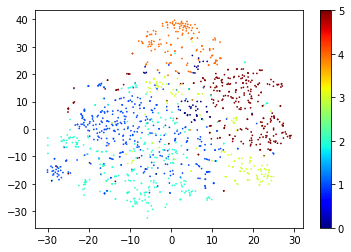

In [49]:
plt.scatter(visual[:,0], visual[:,1], c=table.keyword_index, s=0.5, cmap='jet')
plt.colorbar()
plt.savefig('visualization_tag_discovery.png', dpi=400)

# 我们把数据分割成训练和测试各一半

In [29]:
train_table, test_table = train_test_split(table, test_size=0.5, random_state=6)

# calculate key words, 把tf-idf分数加起来， 就是说词语出现频率高且重要则分数高, 我们找到每一类对应的热词，并把它们组成一个联合向量， 在此基础上，计算每个词语对应每一个类的概率


In [30]:
# find hot words and take the 200 hottest to do classification
# TODO: another way to compute hot words: find words that only appear in one class of articles (pay attention to noise)

def find_hot_words(tf_idfs):
    acc_scores = {}
    for text in tf_idfs:
        for ind, score in text:
            if ind in acc_scores:
                acc_scores[ind] += score
            else:
                acc_scores[ind] = score
    acc_scores = sorted(acc_scores.items(), key = lambda x: x[1], reverse=True)
#     acc_scores = [(dictionary[ind], score) for ind, score in acc_scores]
    return acc_scores
    
# find_hot_words(train_table[train_table.keyword_index == 5].tfidf)[:100]

n_hot_words = 300
hot_words = {}
for ind in range(6):
    hot_words[ind] = {word for word, _ in find_hot_words(train_table[train_table.keyword_index == ind].tfidf)[:n_hot_words]}
    
def word_bags(hot_words,size):
    word_bag={key: list(value)[:size] for key, value in hot_words.items()}
    return word_bag

word_bag=word_bags(hot_words,50)
# word_bag=word_bags(hot_words,300)
all_words = []
for words in word_bag.values():
    all_words.extend(words)
word_bag = {ind: all_words for ind in range(6)}

In [59]:
word_bag

{0: [1024,
  15872,
  17410,
  15875,
  4618,
  4619,
  1035,
  5133,
  6669,
  16911,
  17418,
  15889,
  16914,
  4627,
  6670,
  4629,
  15894,
  4623,
  27,
  17437,
  4640,
  15904,
  4643,
  4644,
  8741,
  39,
  46120,
  6697,
  41,
  15915,
  5164,
  17457,
  15885,
  17459,
  7220,
  4657,
  7224,
  17467,
  1083,
  573,
  16957,
  575,
  7232,
  16961,
  16962,
  10308,
  8261,
  8262,
  71,
  4680,
  8193,
  13314,
  9219,
  5,
  4102,
  1543,
  1544,
  523,
  7180,
  1548,
  1550,
  4625,
  17,
  24086,
  24,
  25,
  27,
  19996,
  29,
  1565,
  24094,
  4125,
  28193,
  546,
  1053,
  39,
  3624,
  41,
  1579,
  1580,
  1581,
  2605,
  559,
  49,
  30258,
  563,
  24628,
  12339,
  3638,
  50,
  8760,
  568,
  11831,
  7739,
  58,
  1588,
  9790,
  1087,
  21570,
  21571,
  1026,
  1030,
  519,
  1544,
  26633,
  26634,
  26635,
  2060,
  12,
  2648,
  3087,
  17,
  1556,
  1046,
  24,
  2585,
  1050,
  27,
  25,
  29,
  36891,
  1053,
  1056,
  544,
  546,
  21538,
  4130

In [21]:
for (word,freq) in list(train_table.corpus)[0]:
      text= (word,freq) 

In [31]:
# new
def feature_form(word_bag,train_table): 
    features_num = train_table.keyword_index.unique()
    features = [{} for i in range(len(features_num))]
    for ind in features_num:
        corpus=train_table[train_table.keyword_index == ind].corpus
        corp=pd.Series([word for word, _ in corpus.sum()])
        dict_corp=dict(corp.groupby(corp).count())
#         print(len(dict_corp))

#         print(type(corp.values[0]))
        for key in word_bag[ind]:
#             occurence=dict_corp[key]
            occurence=dict_corp.get(key, 1)
#             occurence=dict_corp.get(key, 0) + 1
            features[ind][key]=occurence/(len(corpus)) 
#             features[ind][key]=occurence / (len(corpus) + len(word_bag[ind]))
#             for text in (corp):
#                  for  (word,freq) in list(text):
#                     if word==key:
#                         occurence+=1   
    return features

In [32]:
features=feature_form(word_bag,train_table)
features_table=pd.DataFrame(features)
features_table

,0,3,13,14,15,51,53,64,66,68,...,28213,28267,30235,30257,32779,36884,39956,40504,40972,46165
0,0.666667,0.375000,0.208333,0.208333,0.500000,0.875000,0.208333,0.125000,0.458333,0.375000,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
1,0.569149,0.297872,0.117021,0.228723,0.180851,0.563830,0.207447,0.005319,0.244681,0.255319,...,0.005319,0.026596,0.005319,0.042553,0.005319,0.005319,0.005319,0.005319,0.005319,0.005319
2,0.529412,0.272059,0.154412,0.250000,0.161765,0.610294,0.360294,0.029412,0.198529,0.294118,...,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353,0.007353
3,0.643836,0.342466,0.205479,0.191781,0.123288,0.630137,0.082192,0.013699,0.178082,0.273973,...,0.013699,0.013699,0.013699,0.013699,0.013699,0.013699,0.013699,0.013699,0.013699,0.013699
4,0.650000,0.475000,0.125000,0.325000,0.287500,0.537500,0.125000,0.012500,0.100000,0.225000,...,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500
5,0.544828,0.275862,0.103448,0.227586,0.165517,0.544828,0.172414,0.006897,0.144828,0.200000,...,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897,0.006897


In [33]:
def text_prob(text):
    likelihood=ones(6)
    for ind in range(6):
        for word in text:
            if word in word_bag[ind]:
                likelihood[ind]*=features[ind][word]
            else: 
                likelihood[ind]*=1/len(train_table[train_table.keyword_index == ind])
    return liklihood
                
        

In [34]:
class_pbs = []
for ind in range(6):
    pb = sum(train_table.keyword_index == ind) / len(train_table)
    class_pbs.append(pb)

def text_prob(corpus):
    likelihoods = []
    text_words = set(word for word, _ in corpus)
    for ind in range(6):
        likelihood = np.log(class_pbs[ind])
#         ll = 0
        length=sum(train_table.keyword_index == ind)
        for word, pb in features[ind].items():
            if word in text_words:
                likelihood += np.log(pb)
            else:
                likelihood += np.log(1 - pb)
        likelihoods.append(likelihood)
    return likelihoods

def predict_text(corpus):
    pbs = text_prob(corpus)
    return np.argmax(pbs)

In [64]:
class_pbs

[0.037151702786377708,
 0.29102167182662536,
 0.21052631578947367,
 0.1130030959752322,
 0.1238390092879257,
 0.22445820433436534]

In [65]:
b

[-56.784198645648488, -31.832549395677432, -33.68553359479418, -41.226769648838143, -47.255325318153616, -40.245616127039675]
Unnamed: 0                                                        11
content            他曾经在大众点评工作了11年，那时的大众点评一共才有十几个人。他的产品未上线，就获得由中路资...
id                                               6408668216305910273
tags                               ['财经', '创业', '自行车', '大众点评', '基金']
time                                             2017-04-14 09:45:46
title                                  他一个月融资2.5亿，和摩拜、ofo斗争，成共享单车搅局者
doc_words          [曾经, 大众, 点评, 工作, 年, 大众, 点评, 一共, 十几个, 人, 产品, 未,...
corpus             [(25, 4), (27, 5), (29, 5), (59, 1), (70, 1), ...
tfidf              [(25, 0.08854206191160434), (27, 0.03001109462...
visual1                                                      14.6897
visual2                                                     -26.6117
keyword_index                                                      2
predicted_class                               

In [35]:
# predict all test documents
test_table['predicted_class'] = test_table['corpus'].apply(predict_text)

/Volumes/My_Mac/program/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
# compute accuracy
sum(test_table.predicted_class == test_table.keyword_index) / len(test_table)

0.7125193199381762

In [155]:
len(word_bag[0])

300

In [37]:
def cal_probability():
    for word in list(hot_words[2])[:5]: 
        print (dictionary[word])
        
cal_probability()

一个
来说
一些
经营
补贴


In [18]:
train_index = similarities.MatrixSimilarity(train_table['tfidf'])

In [30]:
# example of discovery of new classes/subclasses using visualization
# in the above visualization, the articles of class 4 ('育儿') are visually separated into 2 groups: 
# (x > 10, named 'pos') and (x < -10, 'named 'neg'). the pos group is more about eduation, whereas the neg group
# is more about pregnency and health of mother/child
pos = table[(table['visual1'] >10) & (table.keyword_index == 4)]
neg = table[(table['visual1'] < -0) & (table.keyword_index == 4)]
print([dictionary[ind] for ind, score in find_hot_words(pos.tfidf)][:20])
print([dictionary[ind] for ind, score in find_hot_words(neg.tfidf)][:20])

['孩子', '家长', '教育', '学习', '父母', '妈妈', '爸爸', '成绩', '成长', '婆婆', '方法', '宝宝', '帮助', '分享', '男孩子', '自律性', '老师', '方式', '训练', '培养']
['宝宝', '孩子', '妈妈', '吃', '胎儿', '怀孕', '纸尿裤', '幼儿园', '取名', '名字', '家长', '蔬菜', '姓', '清宫', '食物', '睡', '孕妇', '性别', '肚子', '孕期']


## keyword prediction
different possible metrics:
- TF-IDF
- LDA

diffrent algorithms:
- find list of hot words of each class
- KNN 
- classifiers

In [199]:
def hot_word_predict(corpus):
    text_type = -1
    max_score = 0
    for ind in range(6):
        score = sum(1 if word_ind in hot_words[ind] else 0 for word_ind, _ in corpus)
        if score > max_score:
            text_type = ind
            max_score = score
    return text_type

In [200]:
def word_feature(corpus):
    text_type = -1
    max_score = 0
    score=np.zeros(6)
    for ind in range(6):
        score[ind] = sum(1 if word_ind in hot_words[ind] else 0 for word_ind, _ in corpus)
    return score

In [201]:
# knn method
table_train=train_table.corpus.apply(word_feature)
table_test = test_table.corpus.apply(word_feature)
print (type(table_train.values))

<class 'numpy.ndarray'>


In [202]:
samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5]]
print (type(samples))
from sklearn.neighbors import KNeighborsClassifier
knn =KNeighborsClassifier(n_neighbors=5)
knn.fit(list(table_train.values),train_table.keyword_index)
pre_knn=knn.predict(list(table_test.values))

<class 'list'>


In [203]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
pre_gnb=gnb.fit(list(table_train.values),train_table.keyword_index).predict(list(table_test.values))

In [204]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
pre_mnb=gnb.fit(list(table_train.values),train_table.keyword_index).predict(list(table_test.values))

In [205]:
from sklearn.naive_bayes import BernoulliNB
bnb=BernoulliNB()
pre_bnb=bnb.fit(list(table_train.values),train_table.keyword_index).predict(list(table_test.values))

In [206]:
from sklearn.lda import LDA
lda=LDA()
pre_lda=lda.fit(list(table_train.values),train_table.keyword_index).predict(list(table_test.values))

/home/cruiser/anaconda3/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [207]:
from sklearn.linear_model import Perceptron
percept=Perceptron()
pre_percept=percept.fit(list(table_train.values),train_table.keyword_index).predict(list(table_test.values))

In [208]:
shit = test_table.corpus.apply(hot_word_predict)

In [209]:
sum(test_table.keyword_index == shit)

514

In [210]:
sum(test_table.keyword_index == pre_knn)

525

In [211]:
print (sum(test_table.keyword_index == pre_gnb))
print (sum(test_table.keyword_index == pre_mnb))
print (sum(test_table.keyword_index == pre_bnb))
print (sum(test_table.keyword_index == pre_lda))
print (sum(test_table.keyword_index == pre_percept))

395
395
188
521
528


In [37]:
len(test_table)

647

In [38]:
514 / 647

0.794435857805255

In [39]:
pwd

'/media/cruiser/common/爬虫所得数据'

In [11]:
import pandas as pd
pd.Series([[1,2,3],[11,22,33]]).sum()

[1, 2, 3, 11, 22, 33]